# Belgium train times 

<b><ol>
    <li>Introduction</li>
    <li>Reading and cleaning the dataset</li>
    <li>EDA: Insights from the data</li>
    <li>Delays: Frequency and possible causes</li>
    <li>Modelling: Trying to measure impact on delays</li>
    <li>Conclusions</li>
</ol></b>

### 1. Introduction

This dataset shows the information about train travels in Belgium during a day. Each row represents a train stopping in a station (plus the first departure and the last stop of each travel), so we have the planned schedule of the stopping (the arrival and the departure of the train), the actual time of the arrival and departure, train operator, line, etc.<br>
Delays on arrivals (actual arrival datetime - planned arrival datetime) was considered the most interesting feature for the user, and this is why the exploratory data anaysis is focused on this point and some statistical modelling is carried out in order to identify causes that increases the probability of a train arriving delayed. The work is distributed according this schema:<br><ul>
    <li><u>Reading and cleaning dataset</u>.- importing the file, parsing dates, missing data treatment </li>
    <li><u>EDA: Insights from the data</u>.- Visualizations to understand the Belgium train system </li>
    <li><u>Delays: Frequency and possible causes</u>.- As mentioned, the analysis is focused on delays, so a deeper visualization analysis (mainly bivariate analysis) of arrival delays could guide the modelling work.</li>
    <li><u>Modelling: Trying to measure impact on delays</u>.-</li>

### 2. Reading and cleaning the dataset

In [409]:
#importing libraries
import numpy as np
import pandas as pd
import missingno as msno
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [410]:
#reading file, merging date and time columns for actual and planned arrivals and departures
df = pd.read_csv('https://raw.githubusercontent.com/datacamp/careerhub-data/master/Belgium%20Train%20Times/belgium-train-times.csv', sep=';',
                parse_dates=[[16,5],[17,6],[14,7],[15,8]])

#changing the name of the merged columns
df.columns.values[:4] = ['Actual arrival datetime', 'Actual departure datetime',
                         'Planned arrival datetime', 'Planned departure datetime'] 

#conversion to datetime
df.iloc[:,:4] = df.iloc[:,:4].apply(pd.to_datetime, errors='coerce') 

#Date of departure could be removed (once we have departure datetime)
df.drop('Date of departure', axis=1, inplace=True)

print('Variables and data types:')
df.dtypes

Variables and data types:


Actual arrival datetime       datetime64[ns]
Actual departure datetime     datetime64[ns]
Planned arrival datetime      datetime64[ns]
Planned departure datetime    datetime64[ns]
Train number                           int64
Relation                              object
Railway operator                      object
Departure line                        object
Delay at arrival                     float64
Delay at departure                   float64
Relation direction                    object
Stopping place                        object
Arrival line                          object
dtype: object

In [411]:
nrows = df.shape[0]
first_departure = df['Planned departure datetime'].min()
last_departure = df['Planned departure datetime'].max()

print(f'We have info about the {nrows:,} train routes whose departure was planned between {first_departure} and {last_departure}.')

We have info about the 72,609 train routes whose departure was planned between 2021-02-22 00:01:00 and 2021-02-23 01:37:00.


**Missing data treatment**

In [412]:
print('Missing data per variable:')
df.isna().sum()

Missing data per variable:


Actual arrival datetime       3526
Actual departure datetime     3522
Planned arrival datetime      3526
Planned departure datetime    3530
Train number                     0
Relation                         0
Railway operator                 0
Departure line                3522
Delay at arrival              3526
Delay at departure            3522
Relation direction            5109
Stopping place                   0
Arrival line                  3526
dtype: int64

In [413]:
percentage_complete = df.dropna(axis = 0, how = 'any').shape[0] * 100 / nrows
print(f'The {percentage_complete:.2f}% of the rows are complete' )

The 84.40% of the rows are complete


Correlation among variables


<AxesSubplot:>

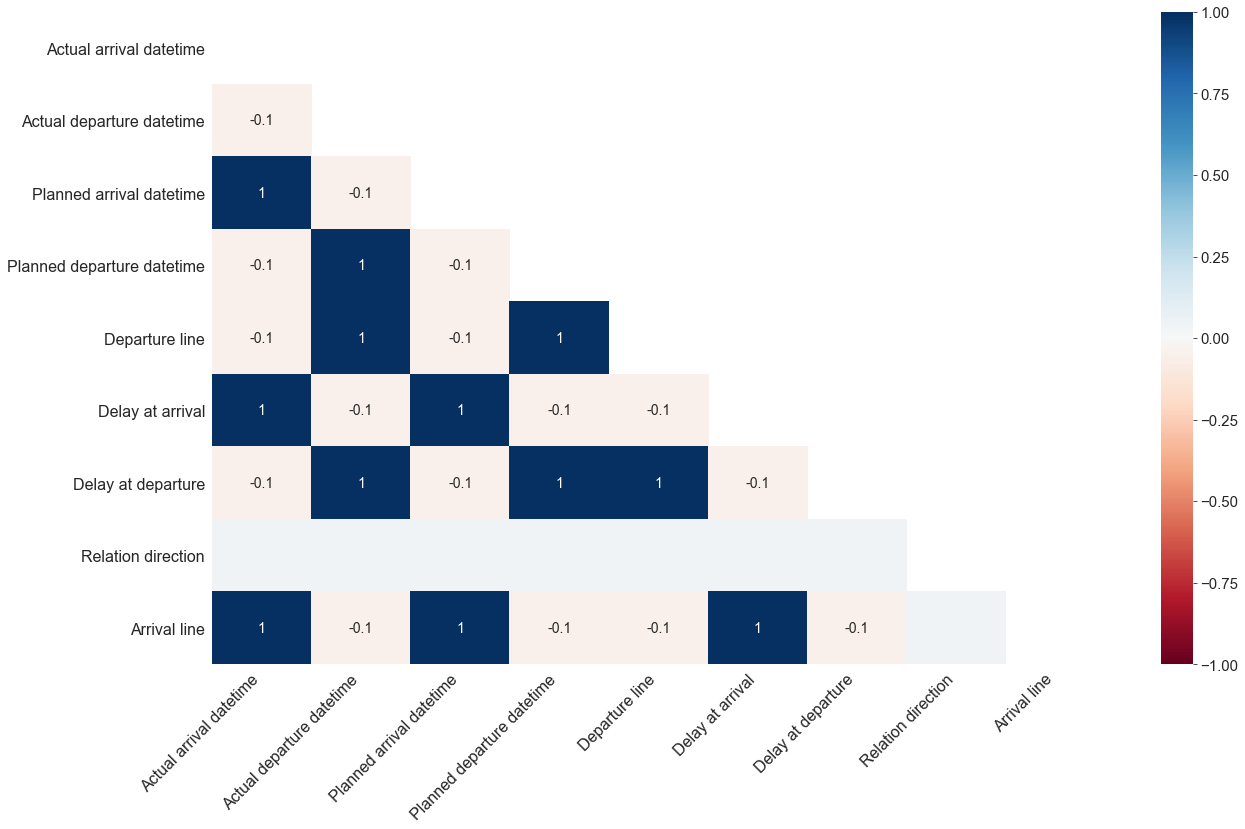

In [414]:
print('Correlation among variables')
msno.heatmap(df)

According to the total NA's per column and the correlation matrix of NA's, it seems the dataset has three types of missing data:<ol>
    <li>3,526 observations with no information of arrival.
    <li>3,522 (8 extra for planned departure datetime) observations with no information of departure.
    <li>5,109 observations with no information about the relation direction.</ol><br>
By now, I am going to keep missing data because it could make sense (no relation direction could mean a one-way travel and no departure/arrival could mean the first/last train of the day). I only going to try to impute the 8 rows that have departure data but miss planned departure datetime.

In [415]:
#Trains with actual departure datetime but missng planned departure datetime.

planned_departure_na = df[(df['Planned departure datetime'].isna())&(~df['Actual departure datetime'].isna())]

#List of tuples with the relaton direction-stopping place pair 
directions_stoppings = list(zip(planned_departure_na['Relation direction'], planned_departure_na['Stopping place']))

print('These are the combinations of relation direction and stopping place with information of departure except planned datetime:')
directions_stoppings

These are the combinations of relation direction and stopping place with information of departure except planned datetime:


[('IC 08: HASSELT -> ANTWERPEN-CENTRAAL', 'DUFFEL'),
 ('IC 08: HASSELT -> ANTWERPEN-CENTRAAL', 'VELTEM'),
 ('L B1-2: NIVELLES -> ANTWERPEN-CENTRAAL', 'VILVOORDE'),
 ('IC 26: SINT-NIKLAAS -> KORTRIJK', 'LEMBEEK'),
 ('IC 18: BRUSSEL-ZUID -> LIEGE-SAINT-LAMBERT', 'FLEMALLE-HAUTE'),
 ('IC 04-1: POPERINGE -> ANTWERPEN-CENTRAAL', 'SINT-NIKLAAS'),
 ('IC 35-1: AMSTERDAM CENTRAAL -> BRUSSEL-ZUID', 'HAREN-ZUID'),
 ('IC 01: EUPEN -> OOSTENDE', 'LEUVEN')]

For instance for the first combination, let's see if there is a constant relation between planned departure and planned arrival:

In [416]:
df_filtered = df[(df['Relation direction']==directions_stoppings[0][0])&(df['Stopping place']==directions_stoppings[0][1])][['Planned arrival datetime','Planned departure datetime']]
print(df_filtered)

      Planned arrival datetime Planned departure datetime
802        2021-02-22 22:00:00        2021-02-22 22:00:00
1184       2021-02-23 00:00:00                        NaT
1307       2021-02-22 14:00:00        2021-02-22 14:00:00
2219       2021-02-22 16:00:00        2021-02-22 16:00:00
2495       2021-02-22 19:00:00        2021-02-22 19:00:00
2633       2021-02-22 23:00:00        2021-02-22 23:00:00
2837       2021-02-22 21:00:00        2021-02-22 21:00:00
3455       2021-02-22 20:00:00        2021-02-22 20:00:00
19480      2021-02-22 15:00:00        2021-02-22 15:00:00
21787      2021-02-22 17:00:00        2021-02-22 17:00:00
22129      2021-02-22 18:00:00        2021-02-22 18:00:00
39293      2021-02-22 07:00:00        2021-02-22 07:00:00
39474      2021-02-22 10:00:00        2021-02-22 10:00:00
46332      2021-02-22 09:00:00        2021-02-22 09:00:00
48116      2021-02-22 12:00:00        2021-02-22 12:00:00
48384      2021-02-22 08:00:00        2021-02-22 08:00:00
49418      202

It is, so I am going to define a function to impute the 8 combinations.

In [417]:
def impute_planned_departure(df, combinations):
    '''This function receives a dataframe and a combination of relation directions and stopping places with all the 
    departure information except the planned datetime. It filters the other trains of the day with this combination and
    checks if there is a constant time lapse between planned arrival datetime and planned departure datetime. If so,
    it imputes the planned departure as planned arrival plus that time lapse.'''
    
    for i in range(len(combinations)):
        #Filter the dataframe with the rows that match the combination
        df_filtered = df.loc[(df['Relation direction'] == combinations[i][0]) & (df['Stopping place'] == combinations[i][1]),['Planned arrival datetime','Planned departure datetime']]
        
        #Get the lapse between planned arrival and planned departure in seconds
        df_filtered['Time in station'] = df_filtered['Planned arrival datetime'] -df_filtered['Planned departure datetime']
        
        #Check if the time lapse in station is constant
        if (df_filtered['Time in station'].max() - df_filtered['Time in station'].min()) == timedelta(0):
            #If so, fill the na with the time lapse
            df_filtered['Time in station'].fillna(df_filtered['Time in station'].mean(), inplace=True)
            #Compute the planned departure as planned arrival + time lapse
            df_filtered['Planned departure datetime'] = df_filtered['Planned arrival datetime'] +  df_filtered['Time in station']
            #Replace the original dataframe
            df.loc[(df['Relation direction'] == directions_stoppings[i][0]) & (df['Stopping place'] == directions_stoppings[i][1]),'Planned departure datetime'] = df_filtered['Planned departure datetime']
    return df
    
    

In [418]:
df = impute_planned_departure(df, directions_stoppings)
print(df.isna().sum())

Actual arrival datetime       3526
Actual departure datetime     3522
Planned arrival datetime      3526
Planned departure datetime    3523
Train number                     0
Relation                         0
Railway operator                 0
Departure line                3522
Delay at arrival              3526
Delay at departure            3522
Relation direction            5109
Stopping place                   0
Arrival line                  3526
dtype: int64


7 of the 8 combinations found a constant interval to impute the planned departure datetime.

### 3. EDA: Insights from the data

* How many train relations are there?

In [419]:
n_relations = len(df.Relation.unique())

print(f'There are {n_relations} different relations.')

There are 105 different relations.


* Are most of the relations round trips? One-way travels? Maybe relations with more than 2 directions? 

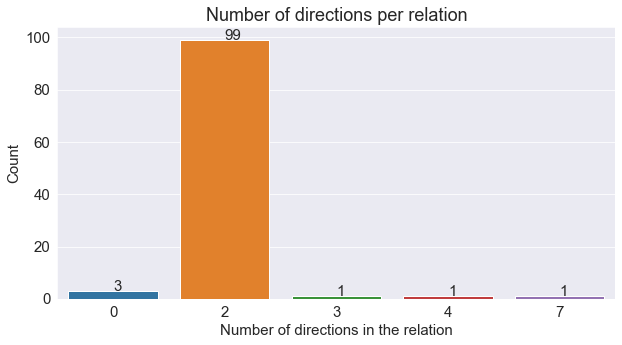

In [420]:
#Number of directions per relations, sorted
relations_vs_directions = df.groupby('Relation')['Relation direction'].nunique()
relations_directions_count = relations_vs_directions.value_counts().sort_index()

#Plot the data
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams.update({'font.size': 15})
sns.set_style("darkgrid")
g = sns.barplot(y=relations_directions_count, x=relations_directions_count.index)
for i,value in enumerate(relations_directions_count.values):
    g.text(i, value, value)
plt.xlabel('Number of directions in the relation')
plt.ylabel('Count')
plt.title('Number of directions per relation')
plt.show()

Almost all the relations seem to be round trips, there are 3 one-way trips and three relations with more than 2 directions.

* The round trips has the same number of stoppings in both directions?

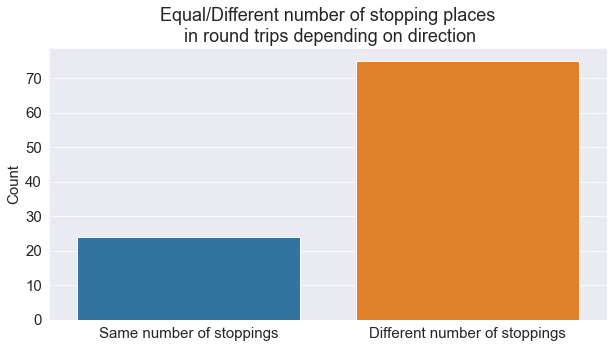

24 round trips have the same number of stoppings in both directions, while 75 have different number of stoppings.


In [421]:
#Filter the round trips in the original dataset
round_trip_relations = relations_vs_directions[relations_vs_directions == 2]
round_trip_df = df[df['Relation'].isin(round_trip_relations.index)]

#Gets the difference in number of stopping places between the 2 directions of the round trip
stops_difference = round_trip_df.groupby(['Relation','Relation direction']).size().diff().abs().groupby('Relation').min()

#Relations with the same number of stopping places in the 2 directions
same_nstops = stops_difference.value_counts()[0]

#Relations with different number of stopping places in the 2 directions
diff_nstops = stops_difference.value_counts().sum() -  same_nstops

#Plotting the data
sns.barplot(y=[same_nstops, diff_nstops], x=['Same number of stoppings', 'Different number of stoppings'])
plt.ylabel('Count')
plt.title('Equal/Different number of stopping places\n in round trips depending on direction')
plt.show()
print(f'{same_nstops} round trips have the same number of stoppings in both directions, while {diff_nstops} have different number of stoppings.')

* What's the distribution of number of stoppings?

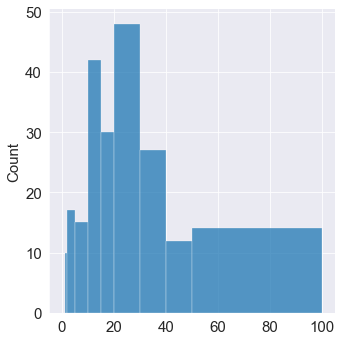

[0, 1)        0
[1, 2)       10
[2, 5)       17
[5, 10)      15
[10, 15)     42
[15, 20)     30
[20, 30)     48
[30, 40)     27
[40, 50)     12
[50, 100)    14
dtype: int64
Most of the have 5-15 stopping places


In [422]:
#Number of stoppings of one-way travels (they miss relation direction data)
one_way_stops = df[df['Relation direction'].isna()].groupby('Relation')['Stopping place'].nunique()

#Number of stoppings of round trips (they miss relation direction data)
round_trip_stops = df.groupby('Relation direction')['Stopping place'].nunique()

#Merging the values
stops = np.concatenate([one_way_stops.values, round_trip_stops.values])
bins=[0,1,2,5,10,15,20,30,40,50,100]

#Plotting the data
sns.displot(stops, bins=bins)
plt.show()
print(pd.cut(stops, bins, right=False).value_counts())
print(f'Most of the have 5-15 stopping places')

* What are the stopping places with more different relations/directions?

In [423]:
#Number of directions
round_trips = df[~df['Relation direction'].isna()].groupby('Stopping place')['Relation direction'].nunique()
#Number of relations in one-way trips
one_way_trips = df[df['Relation direction'].isna()].groupby('Stopping place')['Relation'].nunique()
#Merge of both series
stoppings = pd.merge(one_way_trips, round_trips, how='outer', left_index=True, right_index=True)

In [424]:
busiest_stops = stoppings.sum(axis=1).sort_values(ascending=False)[:10]
print('Number of stops of the busiest stopping places:\n',busiest_stops)

Number of stops of the busiest stopping places:
 Stopping place
BRUSSEL-ZUID           78.0
BRUSSEL-CENTRAAL       69.0
BRUSSEL-CONGRES        69.0
BRUSSEL-KAPELLEKERK    69.0
BRUSSEL-NOORD          69.0
SCHAARBEEK             55.0
ANTWERPEN-CENTRAAL     45.0
ANTWERPEN-BERCHEM      45.0
LEUVEN                 39.0
HALLE                  39.0
dtype: float64


* How many trains are there?

In [425]:
n_trains = len(df['Train number'].unique())
min_ntrain = df['Train number'].min()
max_ntrain = df['Train number'].max()
print(f'There are {n_trains} number of trains')
print(f'They have a number between {min_ntrain} and {max_ntrain} assigned')

There are 3728 number of trains
They have a number between 10 and 19975 assigned


* How many operators are there?

In [426]:
n_operators = len(df['Railway operator'].unique())
print(f'There are {n_operators} railway operators')

There are 3 railway operators


* Is each relation operated by only one railway operator?

In [427]:
print(df.groupby('Relation')['Railway operator'].nunique().max())
print('Yes, there is no relation with more than 1 railway operator')

1
Yes, there is no relation with more than 1 railway operator


* How many relations operates each railway operator?

In [428]:
relations_by_operator = df.groupby('Railway operator')['Relation'].nunique().sort_values(ascending=False)
for operator in relations_by_operator.items():
    print(f'{operator[0]} operates {operator[1]} relations')

SNCB/NMBS operates 103 relations
EUROSTARFR operates 1 relations
THI-FACT operates 1 relations


* How many lines are there?

In [429]:
lines_values = np.concatenate([df['Departure line'].values, df['Arrival line'].values])
unique_lines_values = set(lines_values)
print(f'There are {len(unique_lines_values)} different lines.')

There are 130 different lines.


* How often does the arrival line match the departure line?

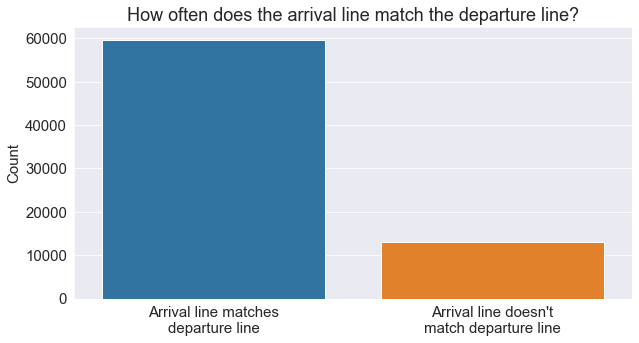

In the 82.18% of the trips the arrival line matches the departure line.


In [430]:
match = len(df[df['Departure line']==df['Arrival line']])
unmatch = len(df[df['Departure line']!=df['Arrival line']])
perc = match*100/len(df)

#Plotting the data
sns.barplot(y=[match, unmatch], x=["Arrival line matches\ndeparture line", "Arrival line doesn't\nmatch departure line"])
plt.ylabel('Count')
plt.title('How often does the arrival line match the departure line?')
plt.show()
print(f'In the {perc:.2f}% of the trips the arrival line matches the departure line.')

* How train departures are scheduled during the day?

Text(0.5, 1.0, 'How train departures are scheduled during the day?')

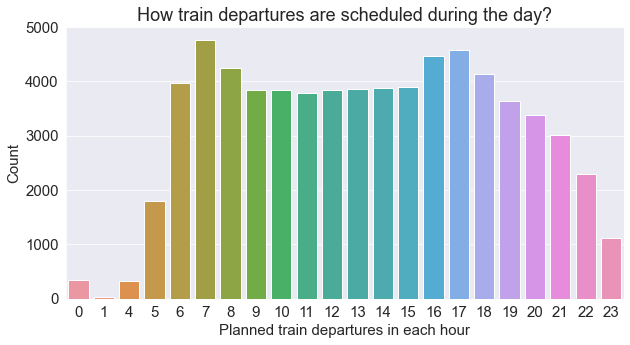

In [431]:
sns.countplot(x=df['Planned departure datetime'].dt.hour.dropna().astype('int'))
plt.xlabel('Planned train departures in each hour')
plt.ylabel('Count')
plt.title('How train departures are scheduled during the day?')

### 4. Delays: Frequency and possible causes

In [432]:
#Adding a column computing the delay increase in the station (departure - arrival)
df.loc[:,'stopping_delay'] = df.loc[:,'Delay at departure'] - df.loc[:,'Delay at arrival']
df.loc[:,'stopping_delay'] = df.loc[:,'stopping_delay']//60

* How often delays occurred?

In [433]:
#Filtering rows with positive delays, in order to drop travels with negative delays at both arrival and departure
delay_df = df[(df['Delay at departure']>0)|(df['Delay at arrival']>0)]
perc_delay = len(delay_df) * 100 / len(df)
print(f'The {perc_delay:.2f}% of the travels was delayed at either arrival or departure.')

The 73.26% of the travels was delayed at either arrival or departure.


* What was the maximum delay?

In [434]:
max_delay_dep = df['Delay at departure'].max()//60
max_delay_arr = df['Delay at arrival'].max()//60
print(f'The maximum delay at departure was {max_delay_dep:.0f} minutes while the maxium delay at arrival was also {max_delay_arr:.0f} minutes.')

The maximum delay at departure was 140 minutes while the maxium delay at arrival was also 140 minutes.


* What's the distribution of delays?

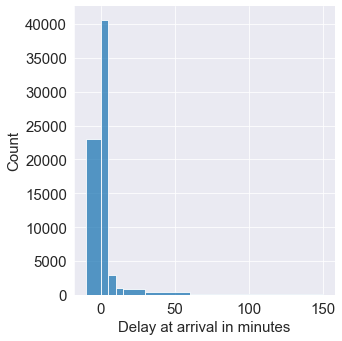

The 31.78% of the delays at arrival was between -10 minutes and 0 (not included).
The 55.91% of the delays at arrival was between 0 minutes and 5 (not included).
The 4.05% of the delays at arrival was between 5 minutes and 10 (not included).
The 1.42% of the delays at arrival was between 10 minutes and 15 (not included).
The 1.22% of the delays at arrival was between 15 minutes and 30 (not included).
The 0.66% of the delays at arrival was between 30 minutes and 60 (not included).
The 0.09% of the delays at arrival was between 60 minutes and 150 (not included).


In [435]:
bins=[-10,0,5,10,15,30,60,150]
sns.displot(df['Delay at arrival']//60,bins=bins)
plt.xlabel('Delay at arrival in minutes')
plt.show()
delay_dep_table = pd.cut(df['Delay at arrival']//60, bins, right=False).value_counts().sort_index()*100/len(df)
for row in delay_dep_table.items():
    print(f'The {row[1]:.2f}% of the delays at arrival was between {row[0].left} minutes and {row[0].right} (not included).')

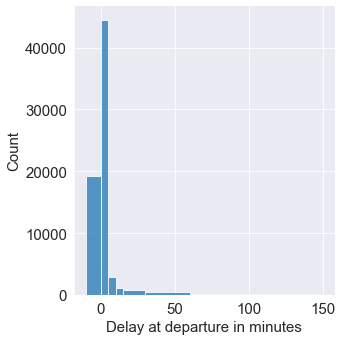

The 26.56% of the delays at departure was between -10 minutes and 0 (not included).
The 61.27% of the delays at departure was between 0 minutes and 5 (not included).
The 3.96% of the delays at departure was between 5 minutes and 10 (not included).
The 1.43% of the delays at departure was between 10 minutes and 15 (not included).
The 1.18% of the delays at departure was between 15 minutes and 30 (not included).
The 0.65% of the delays at departure was between 30 minutes and 60 (not included).
The 0.09% of the delays at departure was between 60 minutes and 150 (not included).


In [436]:
bins=[-10,0,5,10,15,30,60,150]
sns.displot(df['Delay at departure']//60,bins=bins)
plt.xlabel('Delay at departure in minutes')
plt.show()
delay_dep_table = pd.cut(df['Delay at departure']//60, bins, right=False).value_counts().sort_index()*100/len(df)
for row in delay_dep_table.items():
    print(f'The {row[1]:.2f}% of the delays at departure was between {row[0].left} minutes and {row[0].right} (not included).')

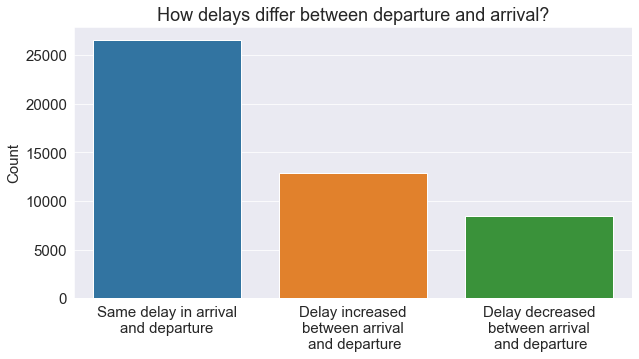

In [437]:
#Filtering only positive delays, avoiding the impact of early arrival/departure on delay averages
delay_df = df[(df['Delay at departure']>0)|(df['Delay at arrival']>0)]


same_delay = len(delay_df[delay_df['Delay at departure'] == delay_df['Delay at arrival']])
more_delay = len(delay_df[delay_df['Delay at departure'] > delay_df['Delay at arrival']])
less_delay = len(delay_df[delay_df['Delay at departure'] < delay_df['Delay at arrival']])

#Plotting the data
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams.update({'font.size': 15})
sns.barplot(y=[same_delay, more_delay, less_delay], x=['Same delay in arrival\nand departure',
                                                       'Delay increased\nbetween arrival\n and departure',
                                                      'Delay decreased\nbetween arrival\n and departure'])
plt.ylabel('Count')
plt.title('How delays differ between departure and arrival?')
plt.show()

* What stops increased delays?

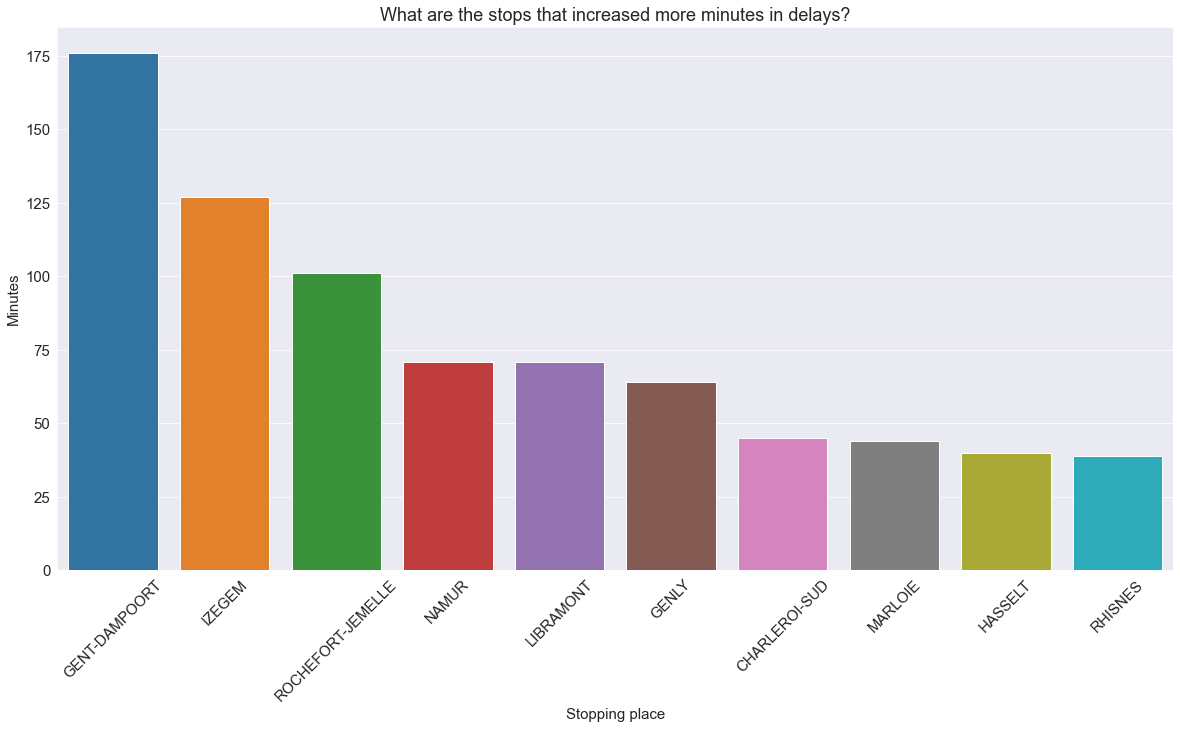

In [438]:
delay_stops_mins = delay_df.groupby('Stopping place').stopping_delay.sum().sort_values(ascending=False)

#Plotting the data
plt.figure(figsize=(20,10))
sns.barplot(y=delay_stops_mins.values[:10], x=delay_stops_mins.index[:10])
plt.ylabel('Minutes')
plt.title('What are the stops that increased more minutes in delays?')
plt.xticks(rotation=45)
plt.show()

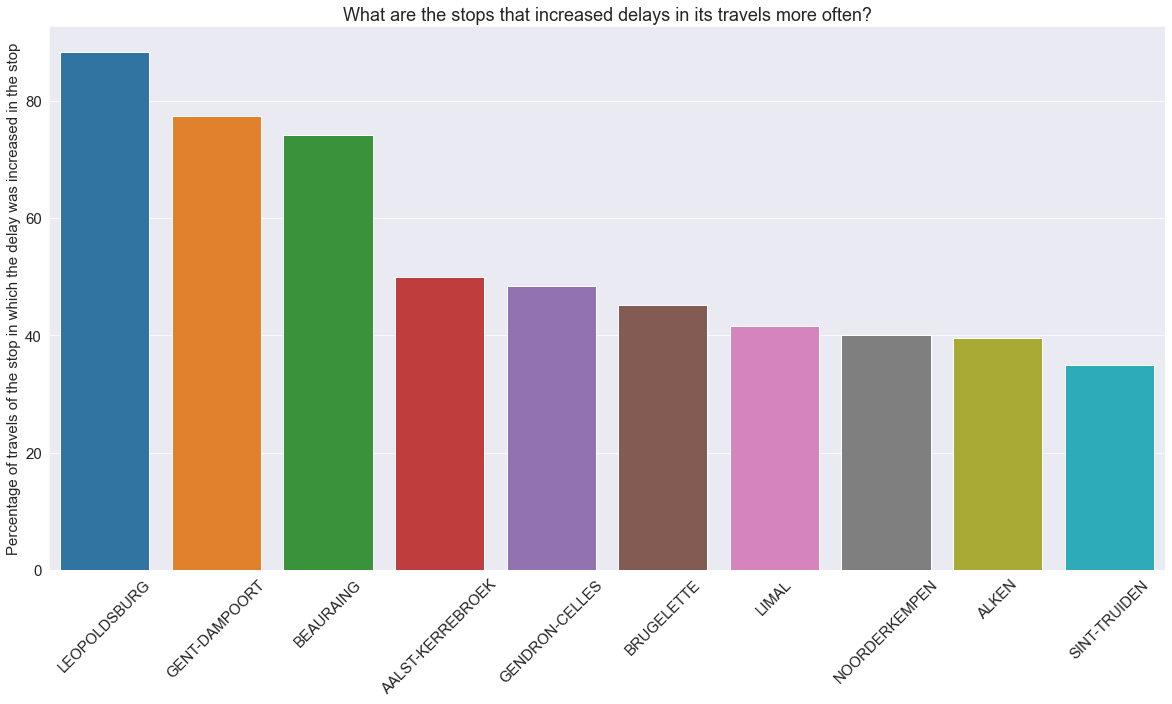

In [439]:
#Percentage of delay increases
total_stop = df['Stopping place'].value_counts()
ndelay_stop = delay_df[delay_df.stopping_delay>0].groupby('Stopping place').stopping_delay.count()
df_delay_stop = pd.merge(total_stop, ndelay_stop, how='outer', left_index=True, right_index=True)
df_delay_stop.loc[:,'Perc_delay'] = df_delay_stop.loc[:,'stopping_delay'] * 100 / df_delay_stop.loc[:,'Stopping place']
df_delay_stop.sort_values('Perc_delay', ascending=False, inplace=True)

#Plotting the data
plt.figure(figsize=(20,10))
sns.barplot(y=df_delay_stop.Perc_delay[:10], x=df_delay_stop.index[:10])
plt.ylabel('Percentage of travels of the stop in which the delay was increased in the stop')
plt.title('What are the stops that increased delays in its travels more often?')
plt.xticks(rotation=45)
plt.show()

* How arrival/departure delays are related with arrival/departure time? 

Text(0.5, 1.0, 'Average departure delay vs hour of departure')

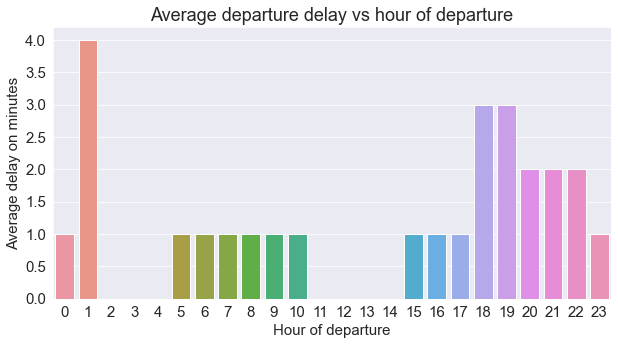

In [440]:
#Average departure delay vs hour of departure
dep_delay_hour = df.groupby(df['Planned departure datetime'].dt.hour)['Delay at departure'].mean()//60

#Filling hours with no data
for i in range(23):
    if not i in dep_delay_hour.index:
        dep_delay_hour.loc[i] = 0
dep_delay_hour.sort_index(inplace=True)
dep_delay_hour = dep_delay_hour.astype('int')
dep_delay_hour.index = dep_delay_hour.index.astype('int')


sns.barplot(y=dep_delay_hour.values, x=dep_delay_hour.index)
plt.ylabel('Average delay on minutes')
plt.xlabel('Hour of departure')
plt.title('Average departure delay vs hour of departure')

Text(0.5, 1.0, 'Average arrival delay vs hour of arrival')

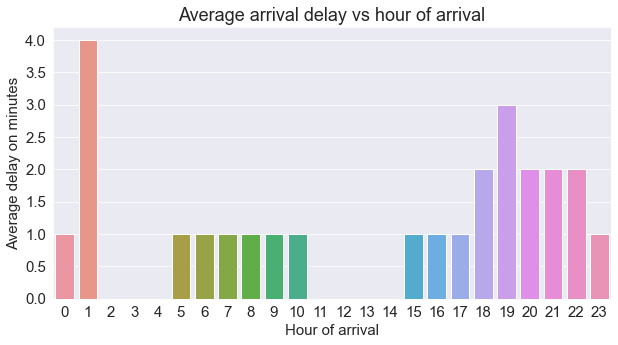

In [441]:
#Average arrival delay vs hour of departure
arr_delay_hour = df.groupby(df['Planned arrival datetime'].dt.hour)['Delay at arrival'].mean()//60

#Filling hours with no data
for i in range(23):
    if not i in arr_delay_hour.index:
        arr_delay_hour.loc[i] = 0
arr_delay_hour.sort_index(inplace=True)
arr_delay_hour = arr_delay_hour.astype('int')
arr_delay_hour.index = arr_delay_hour.index.astype('int')


sns.barplot(y=arr_delay_hour.values, x=arr_delay_hour.index)
plt.ylabel('Average delay on minutes')
plt.xlabel('Hour of arrival')
plt.title('Average arrival delay vs hour of arrival')

In [442]:
#For the rest of the variables the same bivariate analysis will be performed, so defining functions will be helpful

def plot_arrival_delay_sum(variable, ylabel, title, rotation=0):
    '''Plots the top 10 instances of the variable that correspond with higher total delay'''
    
    #Groups by the variable passed as argument, computes the sum, sort the values, and convers to minutes
    sorted_values = delay_df.groupby(variable)['Delay at arrival'].sum().sort_values(ascending=False)//60
    
    #Plotting the data
    sns.barplot(y=sorted_values.values[:10], x=sorted_values.index[:10], order=sorted_values.index[:10])
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.show()

def plot_arrival_delay_mean(variable, ylabel, title, rotation=0):
    '''Plots the top 10 instances of the variable that correspond with higher total delay on average'''
    
    #Groups by the variable passed as argument, computes the mean, sort the values, and convers to minutes
    sorted_values = delay_df.groupby(variable)['Delay at arrival'].mean().sort_values(ascending=False)//60
    
    #Plotting the data
    sns.barplot(y=sorted_values.values[:10], x=sorted_values.index[:10],order=sorted_values.index[:10])
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.show()

* In what relations occurred more delays?

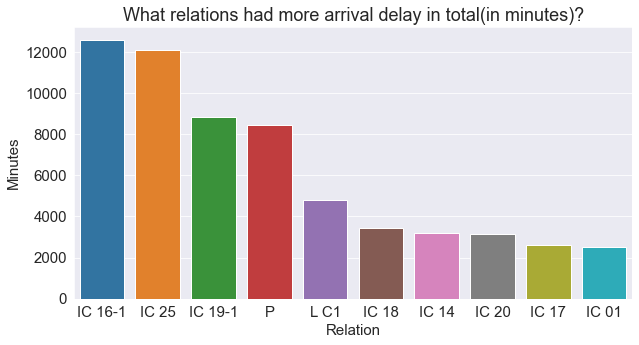

In [443]:
plot_arrival_delay_sum('Relation', 'Minutes', 'What relations had more arrival delay in total(in minutes)?')

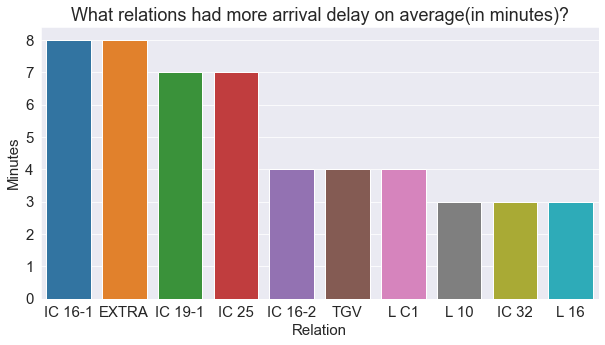

In [444]:
plot_arrival_delay_mean('Relation', 'Minutes', 'What relations had more arrival delay on average(in minutes)?')

* In what relation directions occurred more delays?

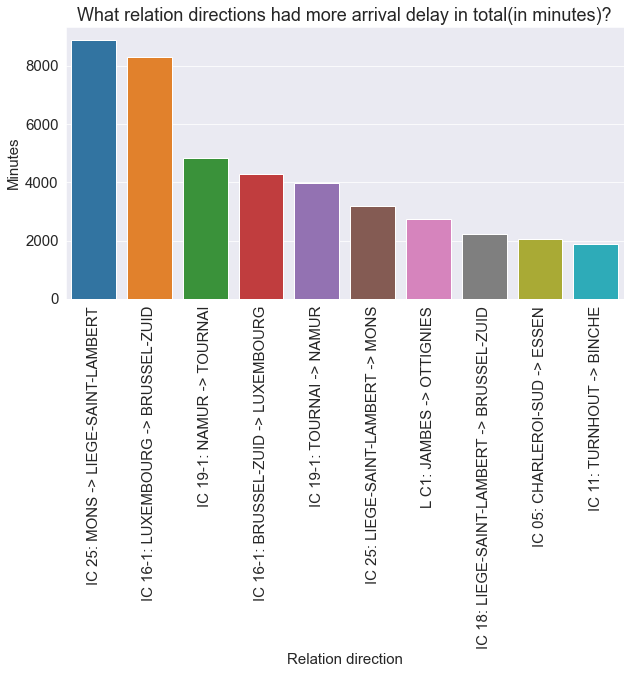

In [445]:
plot_arrival_delay_sum('Relation direction', 'Minutes', 'What relation directions had more arrival delay in total(in minutes)?', 90)

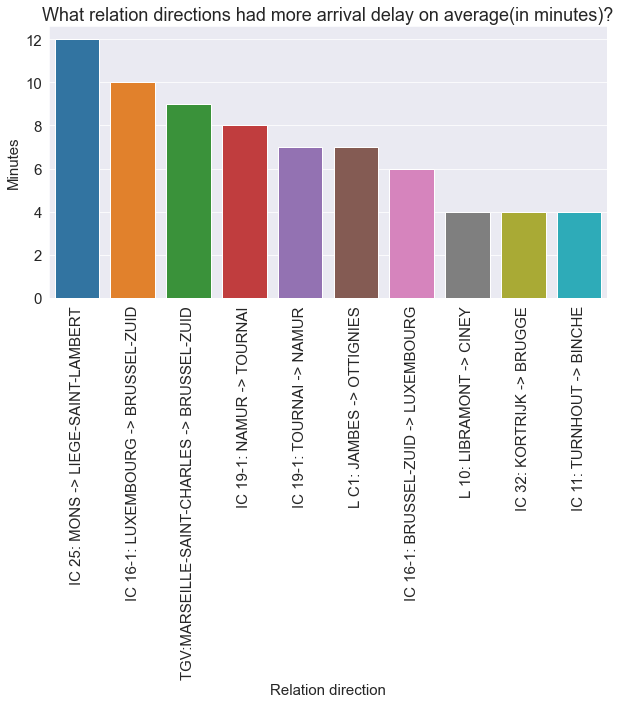

In [446]:
plot_arrival_delay_mean('Relation direction', 'Minutes', 'What relation directions had more arrival delay on average(in minutes)?', 90)

* What railway operator suffered more delay?

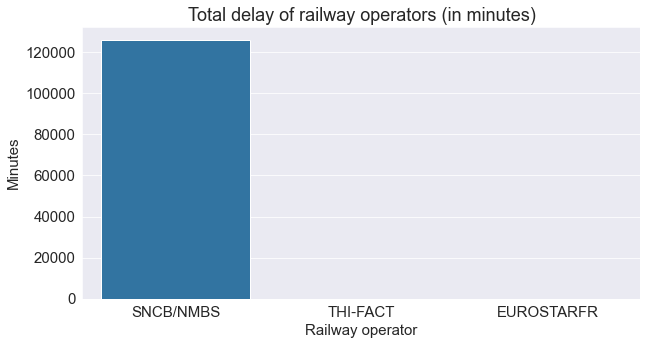

In [447]:
plot_arrival_delay_sum('Railway operator', 'Minutes', 'Total delay of railway operators (in minutes)')

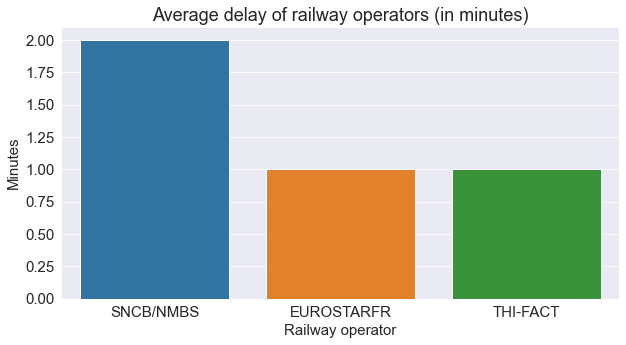

In [448]:
plot_arrival_delay_mean('Railway operator', 'Minutes', 'Average delay of railway operators (in minutes)')

* What trains suffered more delay?

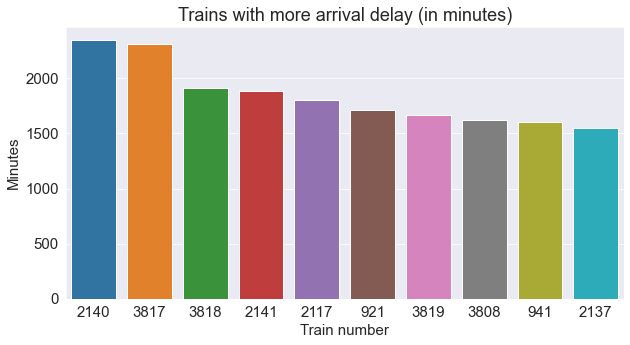

In [449]:
plot_arrival_delay_sum('Train number', 'Minutes', 'Trains with more arrival delay (in minutes)')

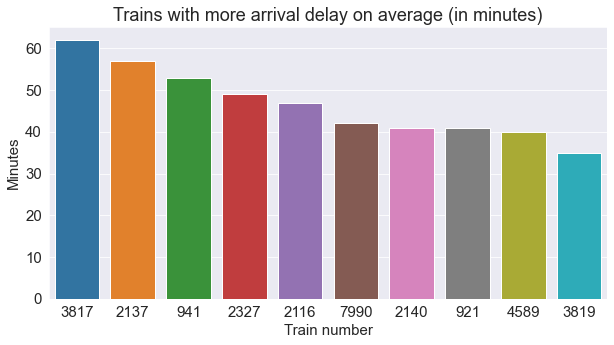

In [450]:
plot_arrival_delay_mean('Train number', 'Minutes', 'Trains with more arrival delay on average (in minutes)')

* In what lines occurred greater delays?

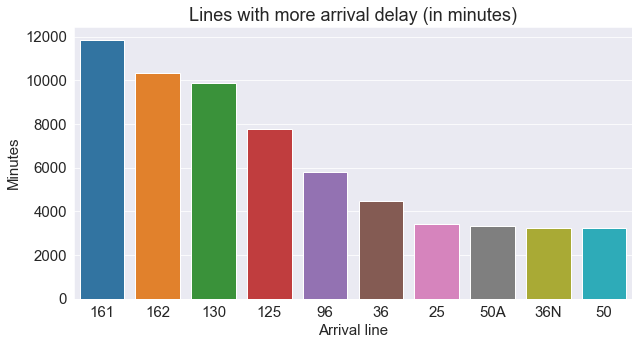

In [451]:
plot_arrival_delay_sum('Arrival line', 'Minutes', 'Lines with more arrival delay (in minutes)')

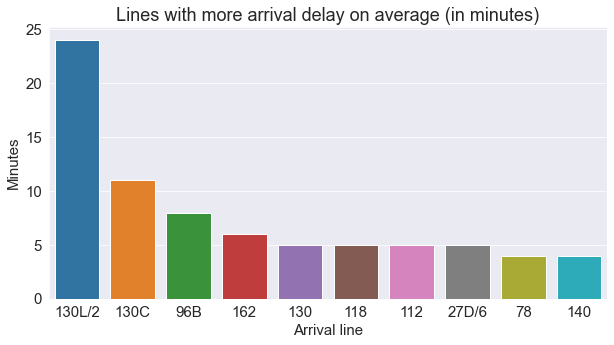

In [452]:
plot_arrival_delay_mean('Arrival line', 'Minutes', 'Lines with more arrival delay on average (in minutes)')

### 4. Modelling: Trying to measure impact on delays

Delays seems to be the most interesting variable for users or management of Belgium train system. Based on that, arrival delay (both arrival and departure delays would be redundant) is the target variable. Then, two decisions have to be made:<ol>
    <li><b>Prediction or inference</b>.- The model could be used for predicting the delay in a train given its specific data, or it could be used to analyze the relationship between the variables and the outcome (delay).</li> 
    <li><b>Regression or classification</b>.- The delay can be measured, so the target variable could be the minutes of delay (regression problem) or whether the train will be delayed or not (classification problem).</li></ol>
In this case, in order to analyze the problems of delays in Belgium trains, it should be treated as an inference classification problem. We want to understand what variables increases the probability of delay and quantify them , so high explainability in the model is needed. For all this, logistic regression is chosen.


**Feature selection**

Categorical variables with a large number of different leves cannot be included, one-hot encoding would cause a very large number of features and other feature engineering techniques like bin counting lacks explainability. So, these are the variables that will be introduced in the regression:<ul>
    <li>Planned arrival hour</li>
    <li>Number of stops in the relation direction or relation (for one way)</li>
    <li>Number of trains stopping in that place during the day</li>

<u>Planned arrival hour</u><br>
According to the EDA, it seems we can group the planned arrival distribution this way:<ol>
    <li>morning: 5-10 </li>
    <li>noon: 11-14</li>
    <li>afternoon: 15-17</li>
    <li>evening-night: 18-4</li>

In [453]:
df['day_slot'] = df['Planned arrival datetime'].dt.hour
df['day_slot'] = pd.cut(df['day_slot'], bins=[-1,4,10,14,17,23],
                        ordered=False,labels=['evening_night','morning','noon','afternoon','evening_night'])
print(df['day_slot'].value_counts())

morning          22292
evening_night    18515
noon             15377
afternoon        12899
Name: day_slot, dtype: int64


<u>Number of stops in the relation/direction</u>

C:\Users\Prueba\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='num_stops'>

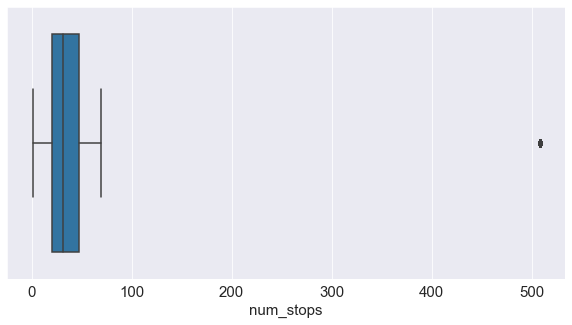

In [454]:
df.loc[:,'num_stops'] = df.loc[:,'Relation direction']
df['num_stops'].fillna(df.Relation, inplace=True)
count_stops = pd.concat([round_trip_stops, one_way_stops])
df.loc[:,'num_stops'] = df.loc[:,'num_stops'].apply(lambda x: count_stops[x])

sns.boxplot(df.num_stops)

C:\Users\Prueba\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='num_stops'>

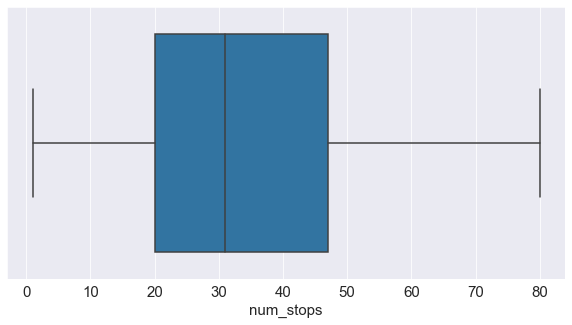

In [455]:
#It seems to be an outlier in 508 let's subsitute it for 80 in order to reduce the levarage of this points in the regression
df['num_stops'].replace(508,80, inplace=True)

sns.boxplot(df.num_stops)

<u>Number of stops in the relation/direction</u>

C:\Users\Prueba\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='num_rels'>

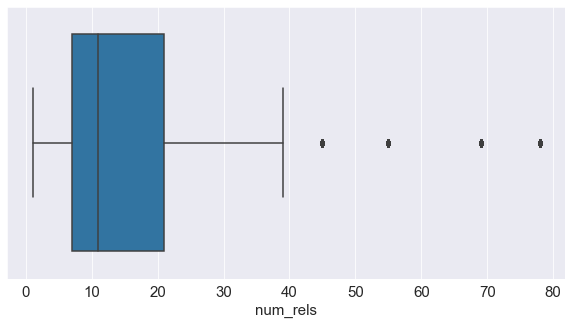

In [456]:
df.loc[:,'num_rels'] = df.loc[:,'Stopping place'].apply(lambda x: stoppings.sum(axis=1)[x])

sns.boxplot(df.num_rels)

<u>Transformation of target variable</u>

In [457]:
df['delay_binary'] = df['Delay at arrival']>0
df['delay_binary'] = df['delay_binary'].astype('int')

In [458]:
#One-hot encoding for the day slot variable
df = df.join(pd.get_dummies(df['day_slot']))
#Filtering complete cases
df.dropna(inplace=True)

<u>Modelling</u>

In [459]:
from statsmodels.formula.api import logit
model = logit('delay_binary~evening_night+morning+noon+afternoon+num_stops+num_rels+0',data=df).fit()

Optimization terminated successfully.
         Current function value: 0.640756
         Iterations 4


In [460]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           delay_binary   No. Observations:                61291
Model:                          Logit   Df Residuals:                    61285
Method:                           MLE   Df Model:                            5
Date:                Thu, 29 Apr 2021   Pseudo R-squ.:                0.004792
Time:                        13:03:14   Log-Likelihood:                -39273.
converged:                       True   LL-Null:                       -39462.
Covariance Type:            nonrobust   LLR p-value:                 1.501e-79
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
evening_night     0.5389      0.025     21.292      0.000       0.489       0.588
morning           0.6270      0.024     25.699      0.000       0.579       0.675
noon              0.2513      0.025      9.948      0.000       0.202       0.301
afternoon         0.6247      0.028     22.473      0.000       0.570       0.679
num_stops         0.0030      0.001      5.366      0.000       0.002       0.004
num_rels          0.0022      0.000      4.502      0.000       0.001       0.003
=================================================================================
"""

<u>Interpretation</u>

In [461]:
#All coefficients are statistically significant different from 0, so this is the interpretation
coefs = model.params
for i,coef in coefs[:4].items():
    print(f'The odds that a train in {i} is delayed increases by a factor of {np.exp(coef):.2f}')
print(f'For each additional stop in the relation the odds that a train is delayed increases by a factor of {np.exp(coefs[4]):.4f}')
print(f'For each additional relation tha stops in that place the odds that a train is delayed increases by a factor of {np.exp(coefs[5]):.4f}')

The odds that a train in evening_night is delayed increases by a factor of 1.71
The odds that a train in morning is delayed increases by a factor of 1.87
The odds that a train in noon is delayed increases by a factor of 1.29
The odds that a train in afternoon is delayed increases by a factor of 1.87
For each additional stop in the relation the odds that a train is delayed increases by a factor of 1.0030
For each additional relation tha stops in that place the odds that a train is delayed increases by a factor of 1.0022


### 6. Conclusions

This dataset shows the Belgium train system information for one day and, after an exhaustive exploratory visualization analysis, an inference approach was chosen. The goal of the analysis is understanding the causes of train delays, in order to help managers to make decisions about them.<br><br>High explainability was prioritized, and for this reason logistic regression was chosen and only a few explanatory variables were included in the model. Considering that the information is referred to only one day, including explanatory variables like train number or train line could bring to wrong conclusions due to spurious correlation.<br><br>One categorical variable (with 4 categories) and two continuous variables were introduced in the model. While the treatment of the continuous variables was straightforward, the introduction of the categorical variable arised the question of wether set a base category or not. In other words, one of the categories could be set as a base case so we can measure how the other categories increases or reduces the probability/odds of delay against the base case, or the model can be fit without base case, being the result a increase/reduction in probability/odds with no comparative case. The latter approach was chosen, and this is why the four categories shows an increase in odds of delay.